In [ ]:
#Basic Initialization

#Code:
 #setting path in colab
 #mount the drive first
from google.colab import drive
drive.mount('/content/drive/', force_remount= True)
import os

#set the working directory 

root_dir = "/content/drive/My Drive/"

#choose the project folder
project_folder = "CIS680HW/HW4b/"

#define a function to create and set the working directory
def create_and_set_working_directory(project_folder):
  #check if the project folder exists. if not, make one.
  if os.path.isdir(root_dir + project_folder) == False:
    os.mkdir(root_dir + project_folder)
    print(root_dir + project_folder + 'did not existed and was created.')
  
  #change the OS path to project folder as working directory
  os.chdir(root_dir + project_folder)

  #create a test file in the working directory and see if it shows up at the right place
  !touch 'new_file_test.txt'
  print('working directory' + root_dir + project_folder + \
        "empty text file created. You can also run !pwd command to confirm working directory.")

create_and_set_working_directory(project_folder)

Mounted at /content/drive/
working directory/content/drive/My Drive/CIS680HW/HW4b/empty text file created. You can also run !pwd command to confirm working directory.


In [ ]:
cd /content/drive/MyDrive/CIS680HW/HW4b

/content


In [ ]:
from BoxHead import BoxHead
from pretrained_models import pretrained_models_680
from dataset import BuildDataLoader, BuildDataset
import torch.optim as optim
from torchvision.models.detection.image_list import ImageList
import torch
import pdb

In [ ]:
import os
os.getcwd()

'/content/drive/.shortcut-targets-by-id/1f8u4JI31JnsegNbVS3RIFA-w-pW653GC/HW4b'

In [ ]:
imgs_path = root_dir + 'CIS680HW' + '/HW3/data/hw3_mycocodata_img_comp_zlib.h5'
masks_path = root_dir + 'CIS680HW'+'/HW3/data/hw3_mycocodata_mask_comp_zlib.h5'
labels_path = root_dir + 'CIS680HW'+'/HW3/data/hw3_mycocodata_labels_comp_zlib.npy'
bboxes_path = root_dir + 'CIS680HW'+'/HW3/data/hw3_mycocodata_bboxes_comp_zlib.npy'
paths = [imgs_path, masks_path, labels_path, bboxes_path]
# load the data into data.Dataset
dataset = BuildDataset(paths)

# New Section

In [ ]:
# build the dataloader
# set 20% of the dataset as the training data
full_size = len(dataset)
train_size = int(full_size * 0.8)
test_size = full_size - train_size
torch.random.manual_seed(1)    
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
    
batch_size = 4
train_build_loader = BuildDataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
train_loader = train_build_loader.loader()
test_build_loader = BuildDataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = test_build_loader.loader()

In [ ]:
epochs = 10
# Put the path were you save the given pretrained model
# pdb.set_trace()
pretrained_path='models/checkpoint680.pth'
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
backbone, rpn = pretrained_models_680(pretrained_path, eval=True)

In [ ]:
# Load your model here. If you use different parameters for the initialization you can change the following code
# accordingly
boxHead = BoxHead()
boxHead=boxHead.to(device)
loadModel = True
model_path = "./model_4B_v6_epoch30.pth"

if loadModel:
  boxHead.load_state_dict(torch.load(model_path))
optimizer = optim.SGD(boxHead.parameters(),lr = 0.0005/batch_size,weight_decay=1.0e-4,momentum=0.90)

In [ ]:


# Put the path were you have your save network
# train_model_path='train_epoch39'
# checkpoint = torch.load(train_model_path)
# reload models
# boxHead.load_state_dict(checkpoint['box_head_state_dict'])
keep_topK=200

cpu_boxes = []
cpu_scores = []
cpu_labels = []
loss_tot = []
loss_class = []
loss_regr = []
val_loss_tot = []
val_loss_class = []
val_loss_regr = []

for e in range(epochs):
    batch_loss = 0
    batch_loss_c = 0
    batch_loss_r = 0
    print("Epoch {}".format(e))
    for i, batch in enumerate(train_loader):
        images = batch['images'].to(device)
        gt_labels = batch['labels']
        boxes = batch['bboxes']
    # Take the features from the backbone
        backout = backbone(images)
        #pdb.set_trace()
        # The RPN implementation takes as first argument the following image list
        im_lis = ImageList(images, [(800, 1088)]*images.shape[0])
        # Then we pass the image list and the backbone output through the rpn
        rpnout = rpn(im_lis, backout)

        #The final output is
        # A list of proposal tensors: list:len(bz){(keep_topK,4)}
        proposals=[proposal[0:keep_topK,:] for proposal in rpnout[0]]
        # A list of features produces by the backbone's FPN levels: list:len(FPN){(bz,256,H_feat,W_feat)}
        fpn_feat_list= list(backout.values())

        class_gt,class_gt_box = boxHead.create_ground_truth(proposals,gt_labels,boxes)
        #print(class_gt[class_gt>0].shape)
        feature_vectors=boxHead.MultiScaleRoiAlign(fpn_feat_list.copy(),proposals.copy())

        class_logits,box_preds=boxHead(feature_vectors.detach())
        
        loss, loss_c, loss_r = boxHead.compute_loss(class_logits, box_preds, class_gt, class_gt_box,l=10.0,effective_batch=60)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print(loss_r)
        batch_loss +=loss.cpu().item()
        batch_loss_c += loss_c.cpu().item()
        batch_loss_r += loss_r.cpu().item()
        loss_tot.append(loss.cpu().item())
        loss_class.append(loss_c.cpu().item())
        loss_regr.append(loss_r.cpu().item())
    print("Total Loss, Loss Class, Loss R: {} {}  {}".format(batch_loss/len(train_loader),batch_loss_c/len(train_loader),batch_loss_r/len(train_loader)))
    
    # Validation Losses
    batch_loss = 0
    batch_loss_c = 0
    batch_loss_r = 0
    max = 50
    for i, batch in enumerate(test_loader):
        images = batch['images'].to(device)
        gt_labels = batch['labels']
        boxes = batch['bboxes']
    # Take the features from the backbone
        backout = backbone(images)
        #pdb.set_trace()
        # The RPN implementation takes as first argument the following image list
        im_lis = ImageList(images, [(800, 1088)]*images.shape[0])
        # Then we pass the image list and the backbone output through the rpn
        rpnout = rpn(im_lis, backout)

        #The final output is
        # A list of proposal tensors: list:len(bz){(keep_topK,4)}
        proposals=[proposal[0:keep_topK,:] for proposal in rpnout[0]]
        # A list of features produces by the backbone's FPN levels: list:len(FPN) {(bz,256,H_feat,W_feat)}
        fpn_feat_list= list(backout.values())

        class_gt,class_gt_box = boxHead.create_ground_truth(proposals,gt_labels,boxes)
        #print(class_gt[class_gt>0].shape)
        feature_vectors=boxHead.MultiScaleRoiAlign(fpn_feat_list.copy(),proposals.copy())

        class_logits,box_preds=boxHead(feature_vectors)
        
        loss, loss_c, loss_r = boxHead.compute_loss(class_logits, box_preds, class_gt, class_gt_box,l=10.0,effective_batch=40)
        batch_loss +=loss.cpu().item()
        batch_loss_c += loss_c.cpu().item()
        batch_loss_r += loss_r.cpu().item()
        if(i>max):
          break
    val_loss_tot.append(batch_loss/max)
    val_loss_class.append(batch_loss_c/max)
    val_loss_regr.append(batch_loss_r/max)
    if(e%3==0):
      torch.save(boxHead.state_dict(), "./model_4B_v6_2_epoch{}.pth".format(e))
torch.save(boxHead.state_dict(), './model_4B_v6_2.pth')

Epoch 0
Total Loss, Loss Class, Loss R: 0.3242018834532729 0.2705207037615374  0.005368117969173549
Epoch 1
Total Loss, Loss Class, Loss R: 0.3168077472322427 0.26450164840880436  0.005230609882343821
Epoch 2
Total Loss, Loss Class, Loss R: 0.3118428179193955 0.2608960960260029  0.005094672189339271
Epoch 3
Total Loss, Loss Class, Loss R: 0.2991236404035463 0.24956087693914336  0.004956276346440302
Epoch 4
Total Loss, Loss Class, Loss R: 0.2998432951380495 0.2517378758781719  0.004810541925987783
Epoch 5
Total Loss, Loss Class, Loss R: 0.29382252958084293 0.2465207444398363  0.004730178514100686
Epoch 6
Total Loss, Loss Class, Loss R: 0.28366909667045165 0.23790794019380535  0.004576115647664658
Epoch 7
Total Loss, Loss Class, Loss R: 0.2799103871976481 0.23488562503918023  0.0045024762158467945
Epoch 8
Total Loss, Loss Class, Loss R: 0.2748871163177768 0.23146293386474687  0.0043424182453029505
Epoch 9
Total Loss, Loss Class, Loss R: 0.2669012859528895 0.2245645308738737  0.0042336755

In [ ]:
epoch = 45
import numpy as np
np.save("loss_tot_epoch{}".format(epoch),np.array(loss_tot))
np.save("loss_class_epoch{}".format(epoch),np.array(loss_class))
np.save("loss_regr_epoch{}".format(epoch),np.array(loss_regr))
np.save("val_loss_tot_epoch{}".format(epoch),np.array(val_loss_tot))
np.save("val_loss_class_epoch{}".format(epoch),np.array(val_loss_class))
np.save("val_loss_regr_epoch{}".format(epoch),np.array(val_loss_regr))

Text(0.5, 1.0, 'Regression Validation Loss')

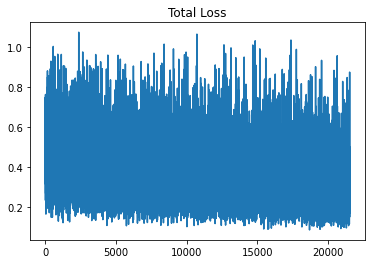

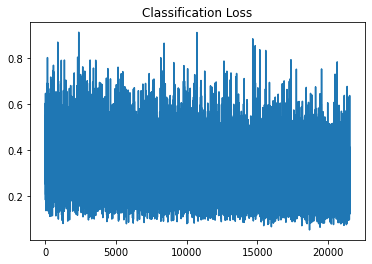

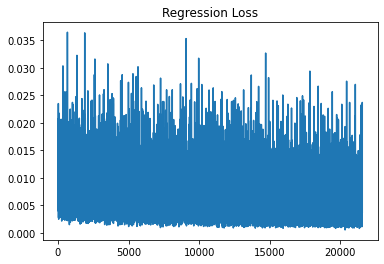

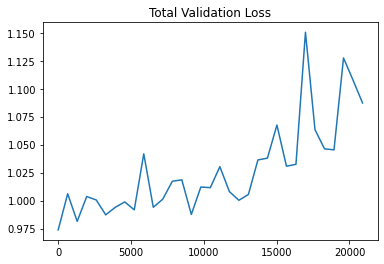

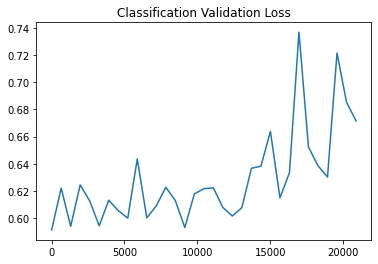

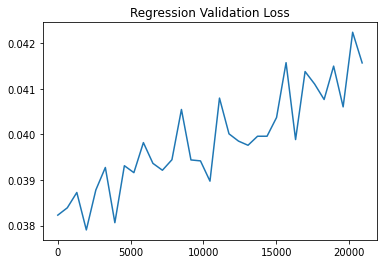

In [ ]:
import matplotlib.pyplot as plt 
plt.figure()
plt.plot(loss_tot)
plt.title('Total Loss')
plt.figure()
plt.plot(loss_class)
plt.title('Classification Loss')
plt.figure()
plt.plot(loss_regr)
plt.title('Regression Loss')
plt.figure()
plt.plot(range(0,int(len(loss_tot)/len(val_loss_tot))*len(val_loss_tot),int(len(loss_tot)/len(val_loss_tot))),val_loss_tot)
plt.title('Total Validation Loss')
plt.figure()
plt.plot(range(0,int(len(loss_class)/len(val_loss_class))*len(val_loss_class),int(len(loss_class)/len(val_loss_class))),val_loss_class)
plt.title('Classification Validation Loss')
plt.figure()
plt.plot(range(0,int(len(loss_class)/len(val_loss_class))*len(val_loss_regr),int(len(loss_regr)/len(val_loss_regr))),val_loss_regr)
plt.title('Regression Validation Loss')